# Regressão Logística usando Softmax no Keras - Iris dataset

Este notebook reproduz o exemplo anterior de Regressão Logística usando o Keras, porém durante o treinamento, podemos acompanhar os gráficos de perda e fronteiras de decisão.

Para se fazer isso no Keras, é preciso utilizar os `call backs` do Keras.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris

import keras
from keras.utils import np_utils 
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.optimizers import SGD

from keras.callbacks import Callback
from IPython import display

Using TensorFlow backend.


## Leitura, normalização e visualização dos dados

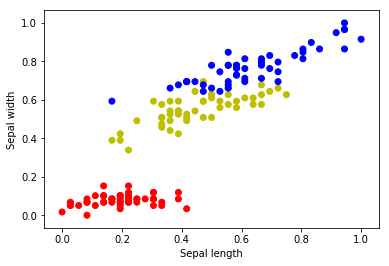

In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
Xc = X - X.min(axis=0)
Xc /= Xc.max(axis=0)

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

## Conversão dos rótulos para o formato one-hot encoding

In [4]:
from keras.utils import np_utils 
Y_oh = np_utils.to_categorical(Y, 3) 
print(Y[0:5])
print(Y_oh[0:5])

[0 0 0 0 0]
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]


## Construindo o modelo da rede

In [6]:
output_dim = nb_classes = 3 
model = Sequential() 
model.add(Dense(output_dim, input_dim=2, activation='softmax',kernel_initializer='zero')) 

## Compilação do modelo

In [7]:
sgd = SGD(lr=0.15)
model.compile(optimizer=sgd, loss='categorical_crossentropy') 

## Callback para visualização dinâmica

In [8]:
class BoundaryPlotter(Callback):
    def __init__(self,X,Y,n_epoch, filepath=None,h = .01):
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        
    def on_epoch_end(self,epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            if epoch%1000==0: 
                plt.subplot(121)
                plt.plot(np.arange(epoch+1),self.loss_hist,'b',linewidth = 2.0)
                plt.subplot(122)
                Z = self.model.predict_classes(self.X_grid,verbose=0).reshape(self.xx.shape)
                plt.figure(1, figsize=(4, 3))
                plt.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                plt.scatter(self.X[:, 0], self.X[:, 1], s=400, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)
                
                display.display(plt.gcf())
                display.clear_output(wait=True)
                

## Laço principal de treinamento da Regressão Logística por Softmax

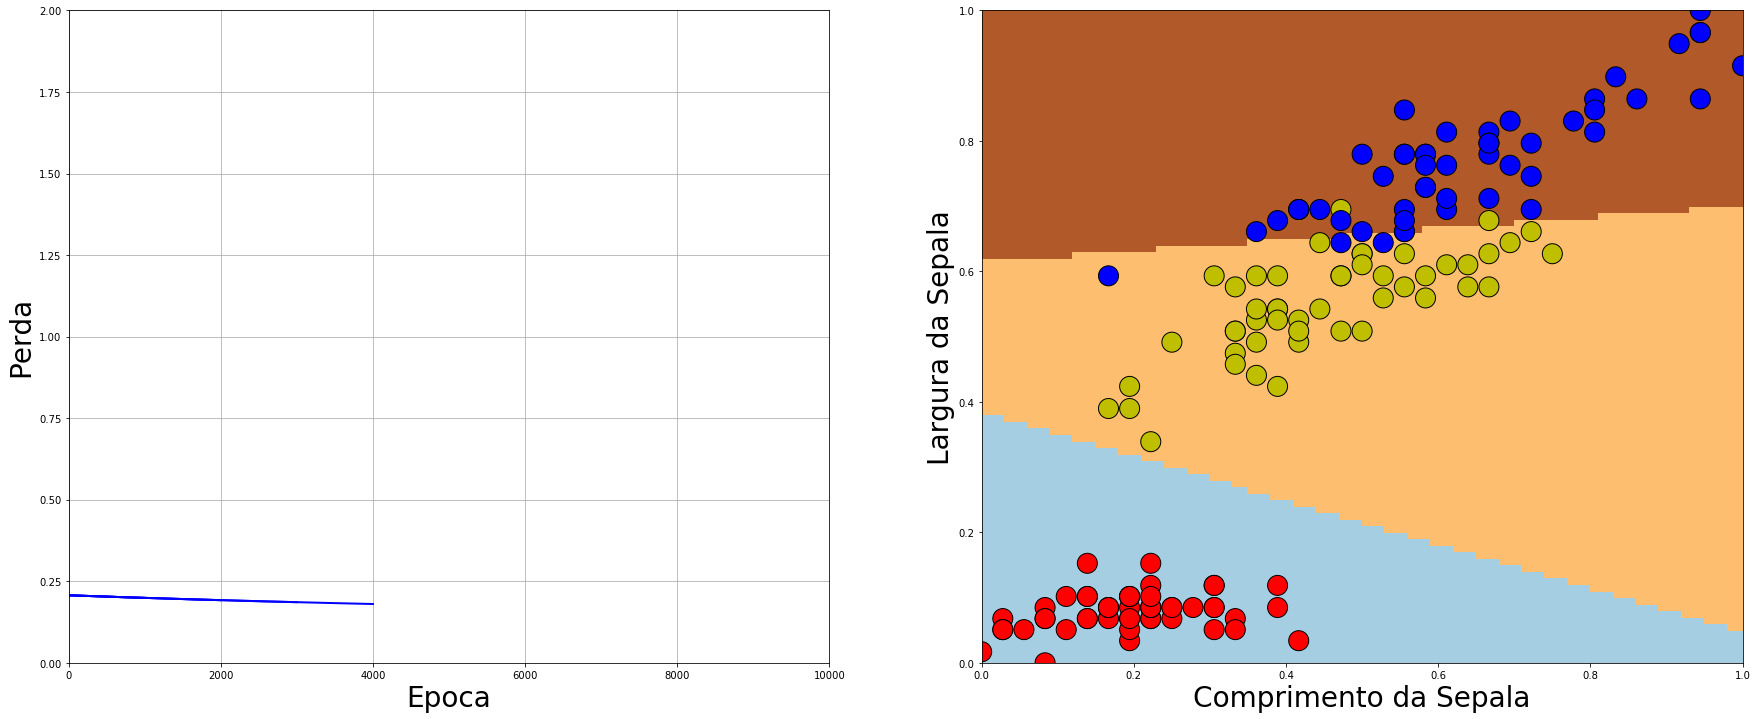

In [10]:
batch_size = 150
nb_epoch = 10000

#Definindo o callback
boundary_plot = BoundaryPlotter(Xc,Y,nb_epoch)

#Gráficos a serem mostrados pelo callback
ploss = 2.0
fig = plt.figure(figsize=(30,12))
plt.subplot(121)
#plt.plot(0.0,ploss)
plt.ylim(0.0, ploss)
plt.xlim(0, nb_epoch)
plt.xlabel('Epoca',fontsize=28)
plt.ylabel('Perda',fontsize=28)
plt.plot(-1,-1,'b',linewidth = 2.0,label = "Treino")
plt.grid(True)

plt.subplot(122)
plt.xlim(Xc[:,0].min(), Xc[:,0].max())
plt.ylim(Xc[:,1].min(), Xc[:,1].max())
plt.xlabel('Comprimento da Sepala',fontsize=28)
plt.ylabel('Largura da Sepala',fontsize=28)

n = Xc.shape[0] # number of training examples

try:
    history = model.fit(Xc, Y_oh, batch_size=batch_size, epochs=nb_epoch,callbacks = [boundary_plot],verbose=0)
except KeyboardInterrupt:
    pass


## Imprimindo loss e W finais

In [12]:
loss = model.evaluate(Xc, Y_oh, verbose=0)
print('Final loss:',loss)

W = model.get_weights()
print('Bias:\n', W[1])
print('W:\n', W[0])

Final loss: 0.180262133876
Bias:
 [ 7.8693738   2.03839421 -9.90754318]
W:
 [[ -2.91451001   2.29798031   0.61652923]
 [-16.80187225  -1.38396704  18.18567467]]


## Avaliação do classificador

In [13]:
Y_hat = model.predict_classes(Xc)
accuracy = sum(Y_hat == Y)/(float(len(Y)))
print() 
print('Training Accuracy: ', accuracy)

print('Matriz de confusão:')
import pandas as pd
pd.crosstab(Y_hat, Y)

 32/150 [=====>........................] - ETA: 0s
Training Accuracy:  0.96
Matriz de confusão:


col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Atividades

### Perguntas:
1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?

### Experimentos:
1. Experimente refazer o treinamento com diferentes valores de learning rate
2. Mude a inicialização dos parâmetros para a inicialização *default* do Keras
3. Melhore alguma visualização nos gráfico
4. Troque os atributos utilizados no `X` por outros dois, por exemplo o primeiro é segundo:
    `X = iris.data[:,:2]  # comprimento e largura das sépalas, indices 0 e 1``



## Principais aprendizados